# The ``delay_dist`` Argument

Normally in PyROA, a single parameter is used for blurring through the sliding window: $\Delta$. This means that the transfer function between light curves is a dirac delta distribution, centered on $\tau$. 

PyROA also has the functionality to generalize the transfer function to a number of different distributions. In simpler terms, PyROA will convolve the driving light curve with this transfer function to obtain the input light curves.

Instead of having only a single delay parameter $\tau_i$ for each line light curve, including a generalized transfer function can give an RMS of this "delay distribution" around the mean $\Delta_i$. For a more in-depth explanation of the delay distribution feature, see [PyROA's tutorial](https://github.com/FergusDonnan/PyROA/blob/main/examples/Delay_Distribution_Tutorial.ipynb).

We can tell pyPetal to use a delay distribution by setting ``delay_dist=True`` in the PyROA parameters. By default, the delay distribution will be a Gaussian for each line light curve. However, this can be changed with the ``psi_types`` argument. This can either be input as an array of distributions, or a single distribution that will apply to each line.

The possible distributions to choose from are:

* "Gaussian"
* "Uniform"
* "LogGaussian"
* "InverseGauss" - An inverse Gaussian
* "TruncGaussian" - A truncated Gaussian, truncated at the minimum delay

## An Example Run

We'll use the same example as in the basic PyROA test, but now set ``delay_dist=True``:

In [1]:
%matplotlib inline
import pypetal.pipeline as pl

main_dir = 'pypetal/examples/dat/javelin_'
line_names = ['continuum', 'yelm', 'zing']
filenames = [ main_dir + x + '.dat' for x in line_names ]

output_dir = 'pyroa_output3/'


Running PyROA
----------------
nburn: 4000
nchain: 7000
init_tau: [10.0, 100.0]
subtract_mean: True
div_mean: False
add_var: True
delay_dist: True
psi_types: ['Gaussian', 'Gaussian']
together: True
objname: pyroa
----------------
        
Initial Parameter Values
     A0           B0    σ0       A1           B1    τ1    Δ1    σ1      A2          B2    τ2    Δ2    σ2    Δ
-------  -----------  ----  -------  -----------  ----  ----  ----  ------  ----------  ----  ----  ----  ---
2.30824  7.53021e-16  0.01  1.19302  4.11909e-16    10     1  0.01  0.5882  3.6042e-16   100     1  0.01   10
NWalkers=32


  0%|          | 0/7000 [00:00<?, ?it/s]/home/stone28/miniconda3/envs/pypetal_test/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 7000/7000 [16:30<00:00,  7.06it/s]


Filter: continuum
Mean Delay, error: 0.00 (fixed)
Filter: yelm
Mean Delay, error:  100.30587  (+   1.05256 -   1.07672)
Filter: zing
Mean Delay, error:  250.46164  (+   0.85220 -   0.85280)


Best Fit Parameters
     A0          B0        σ0       A1         B1       τ1       Δ1        σ1       A2          B2       τ2       Δ2         σ2        Δ
-------  ----------  --------  -------  ---------  -------  -------  --------  -------  ----------  -------  -------  ---------  -------
2.27656  0.00313276  0.342644  1.17602  -0.022431  100.306  2.25189  0.188017  0.58181  0.00710146  250.462  1.64259  0.0849625  11.9723


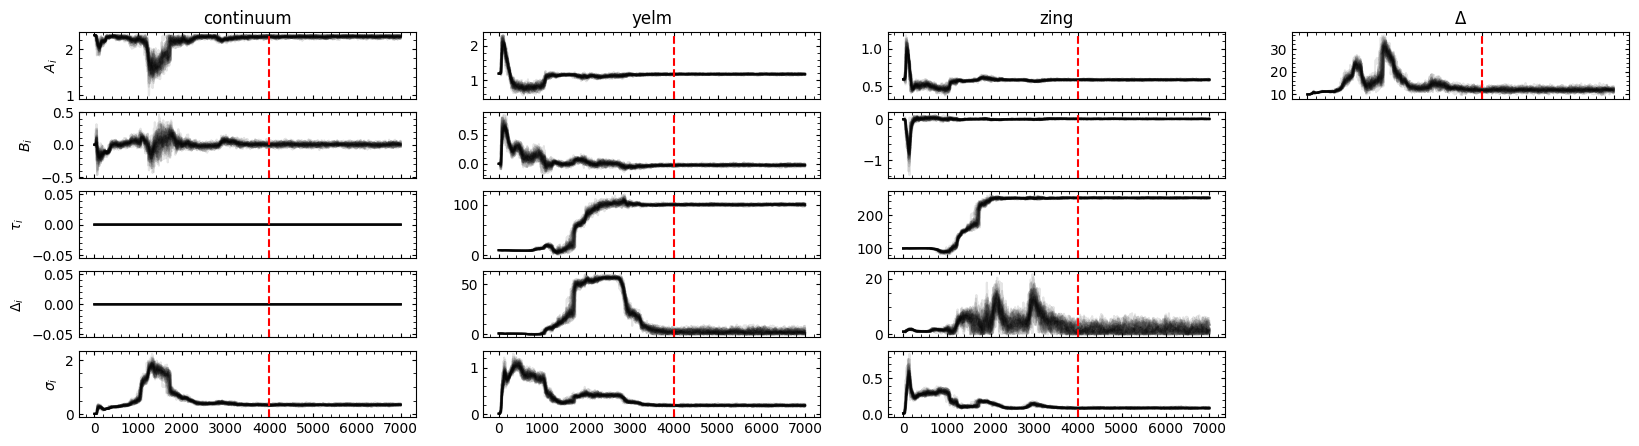

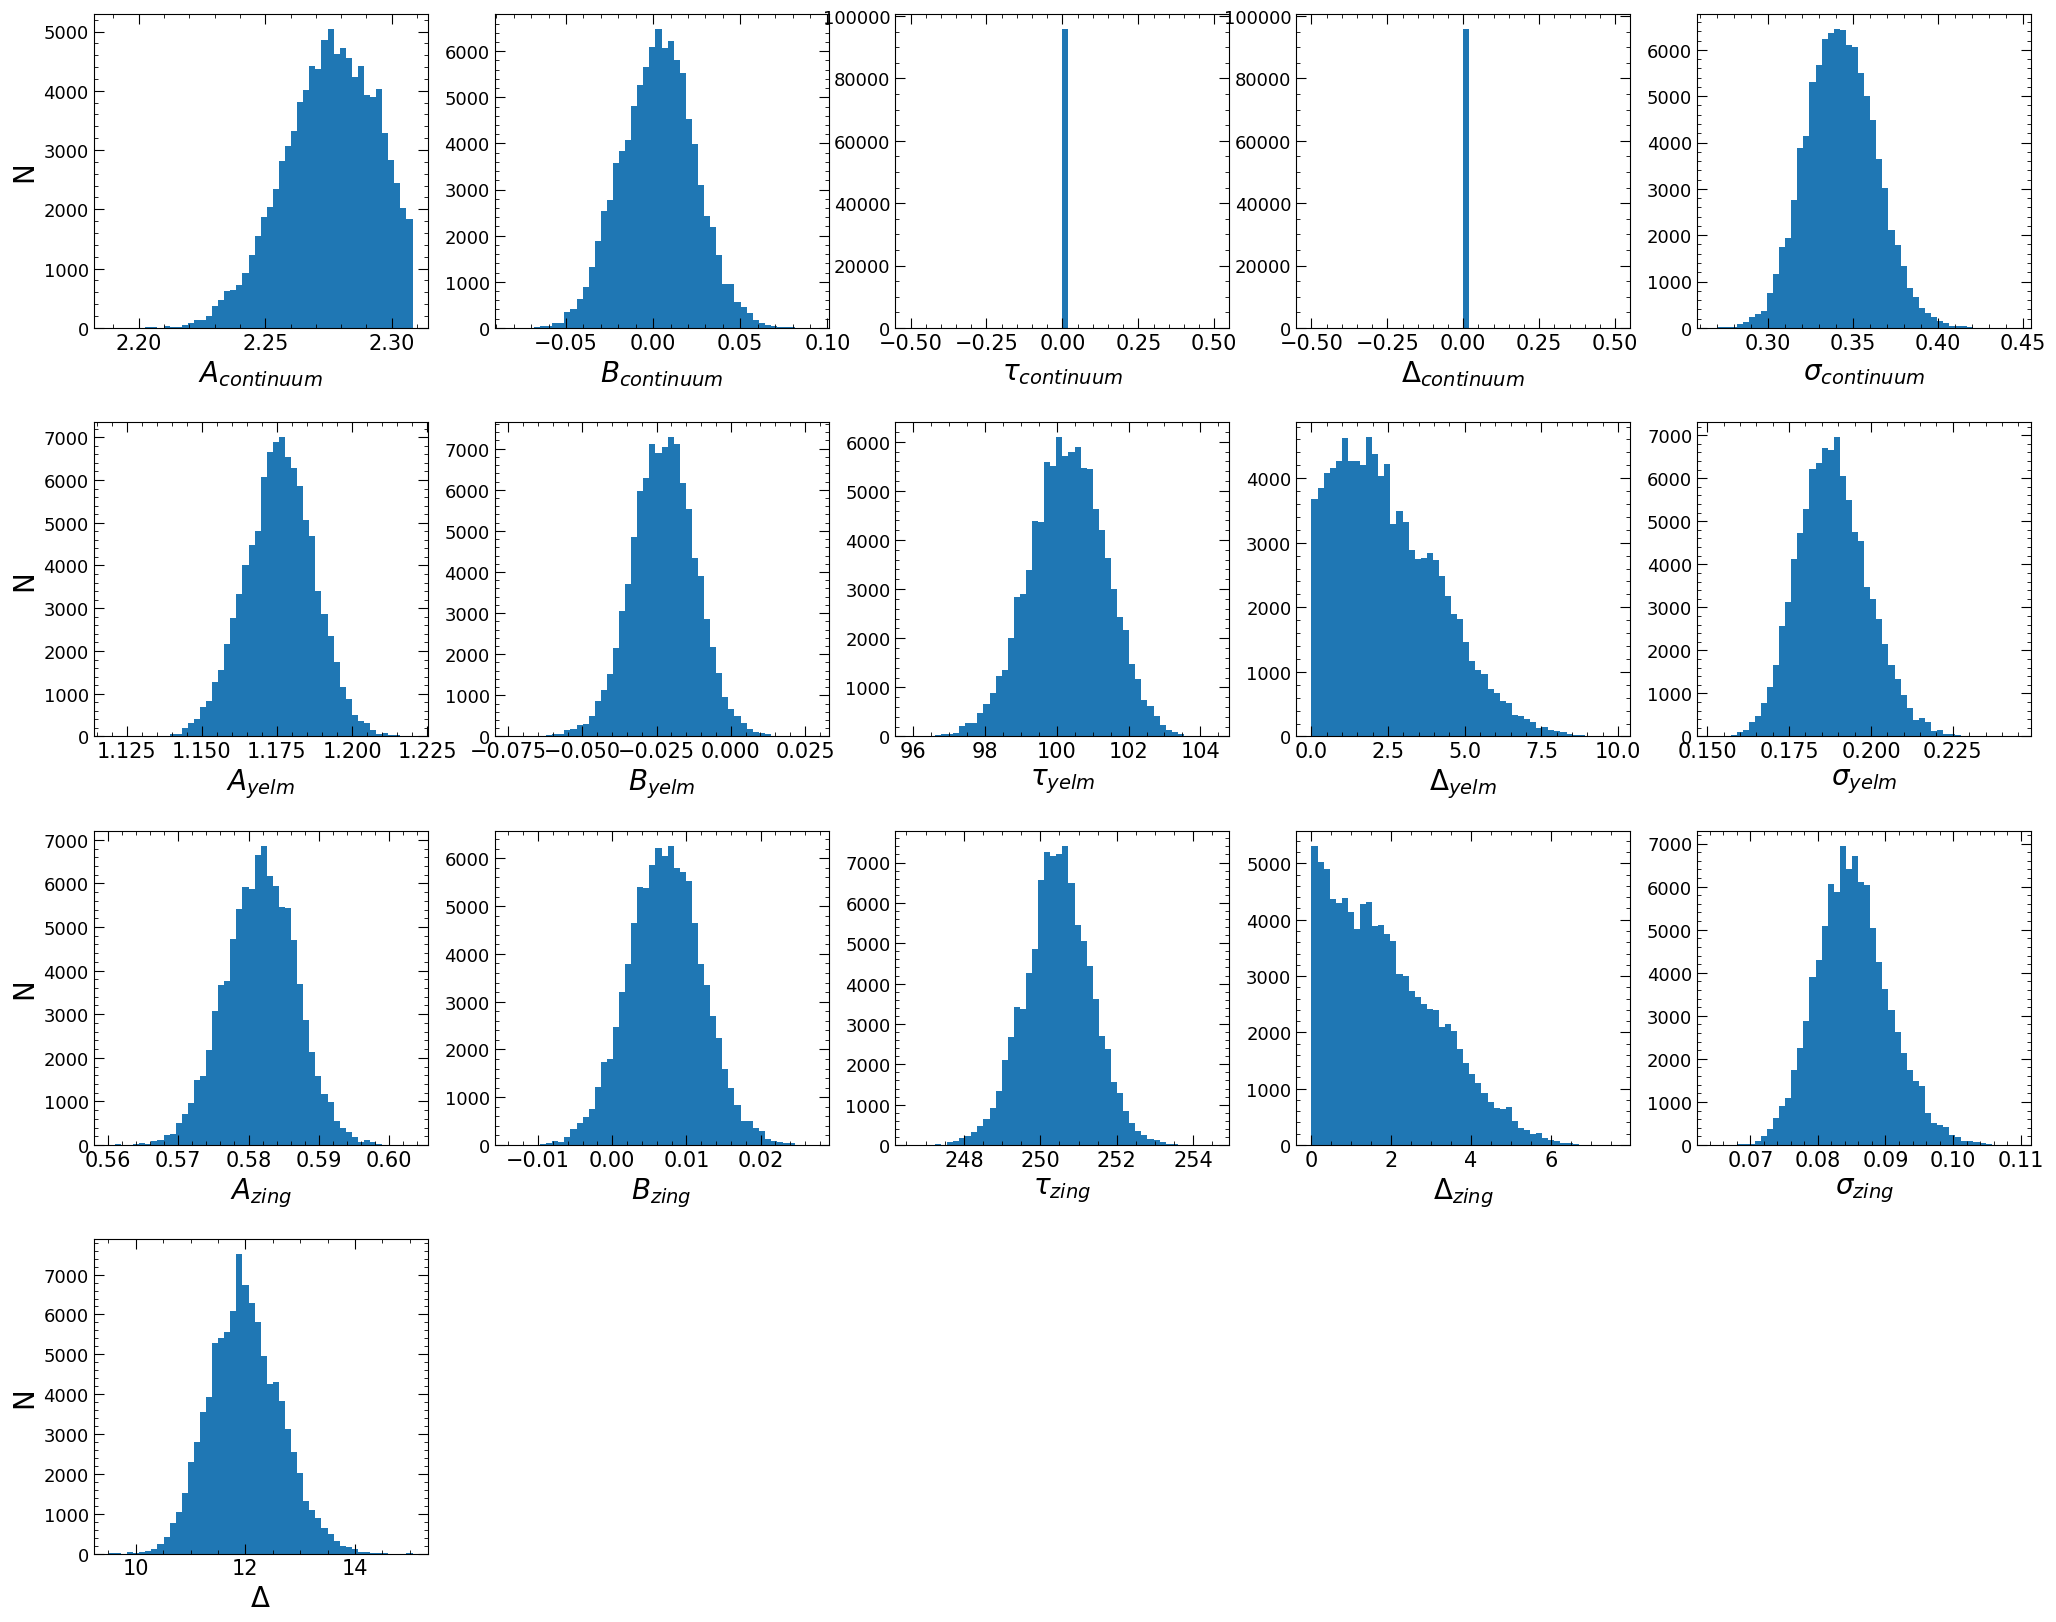

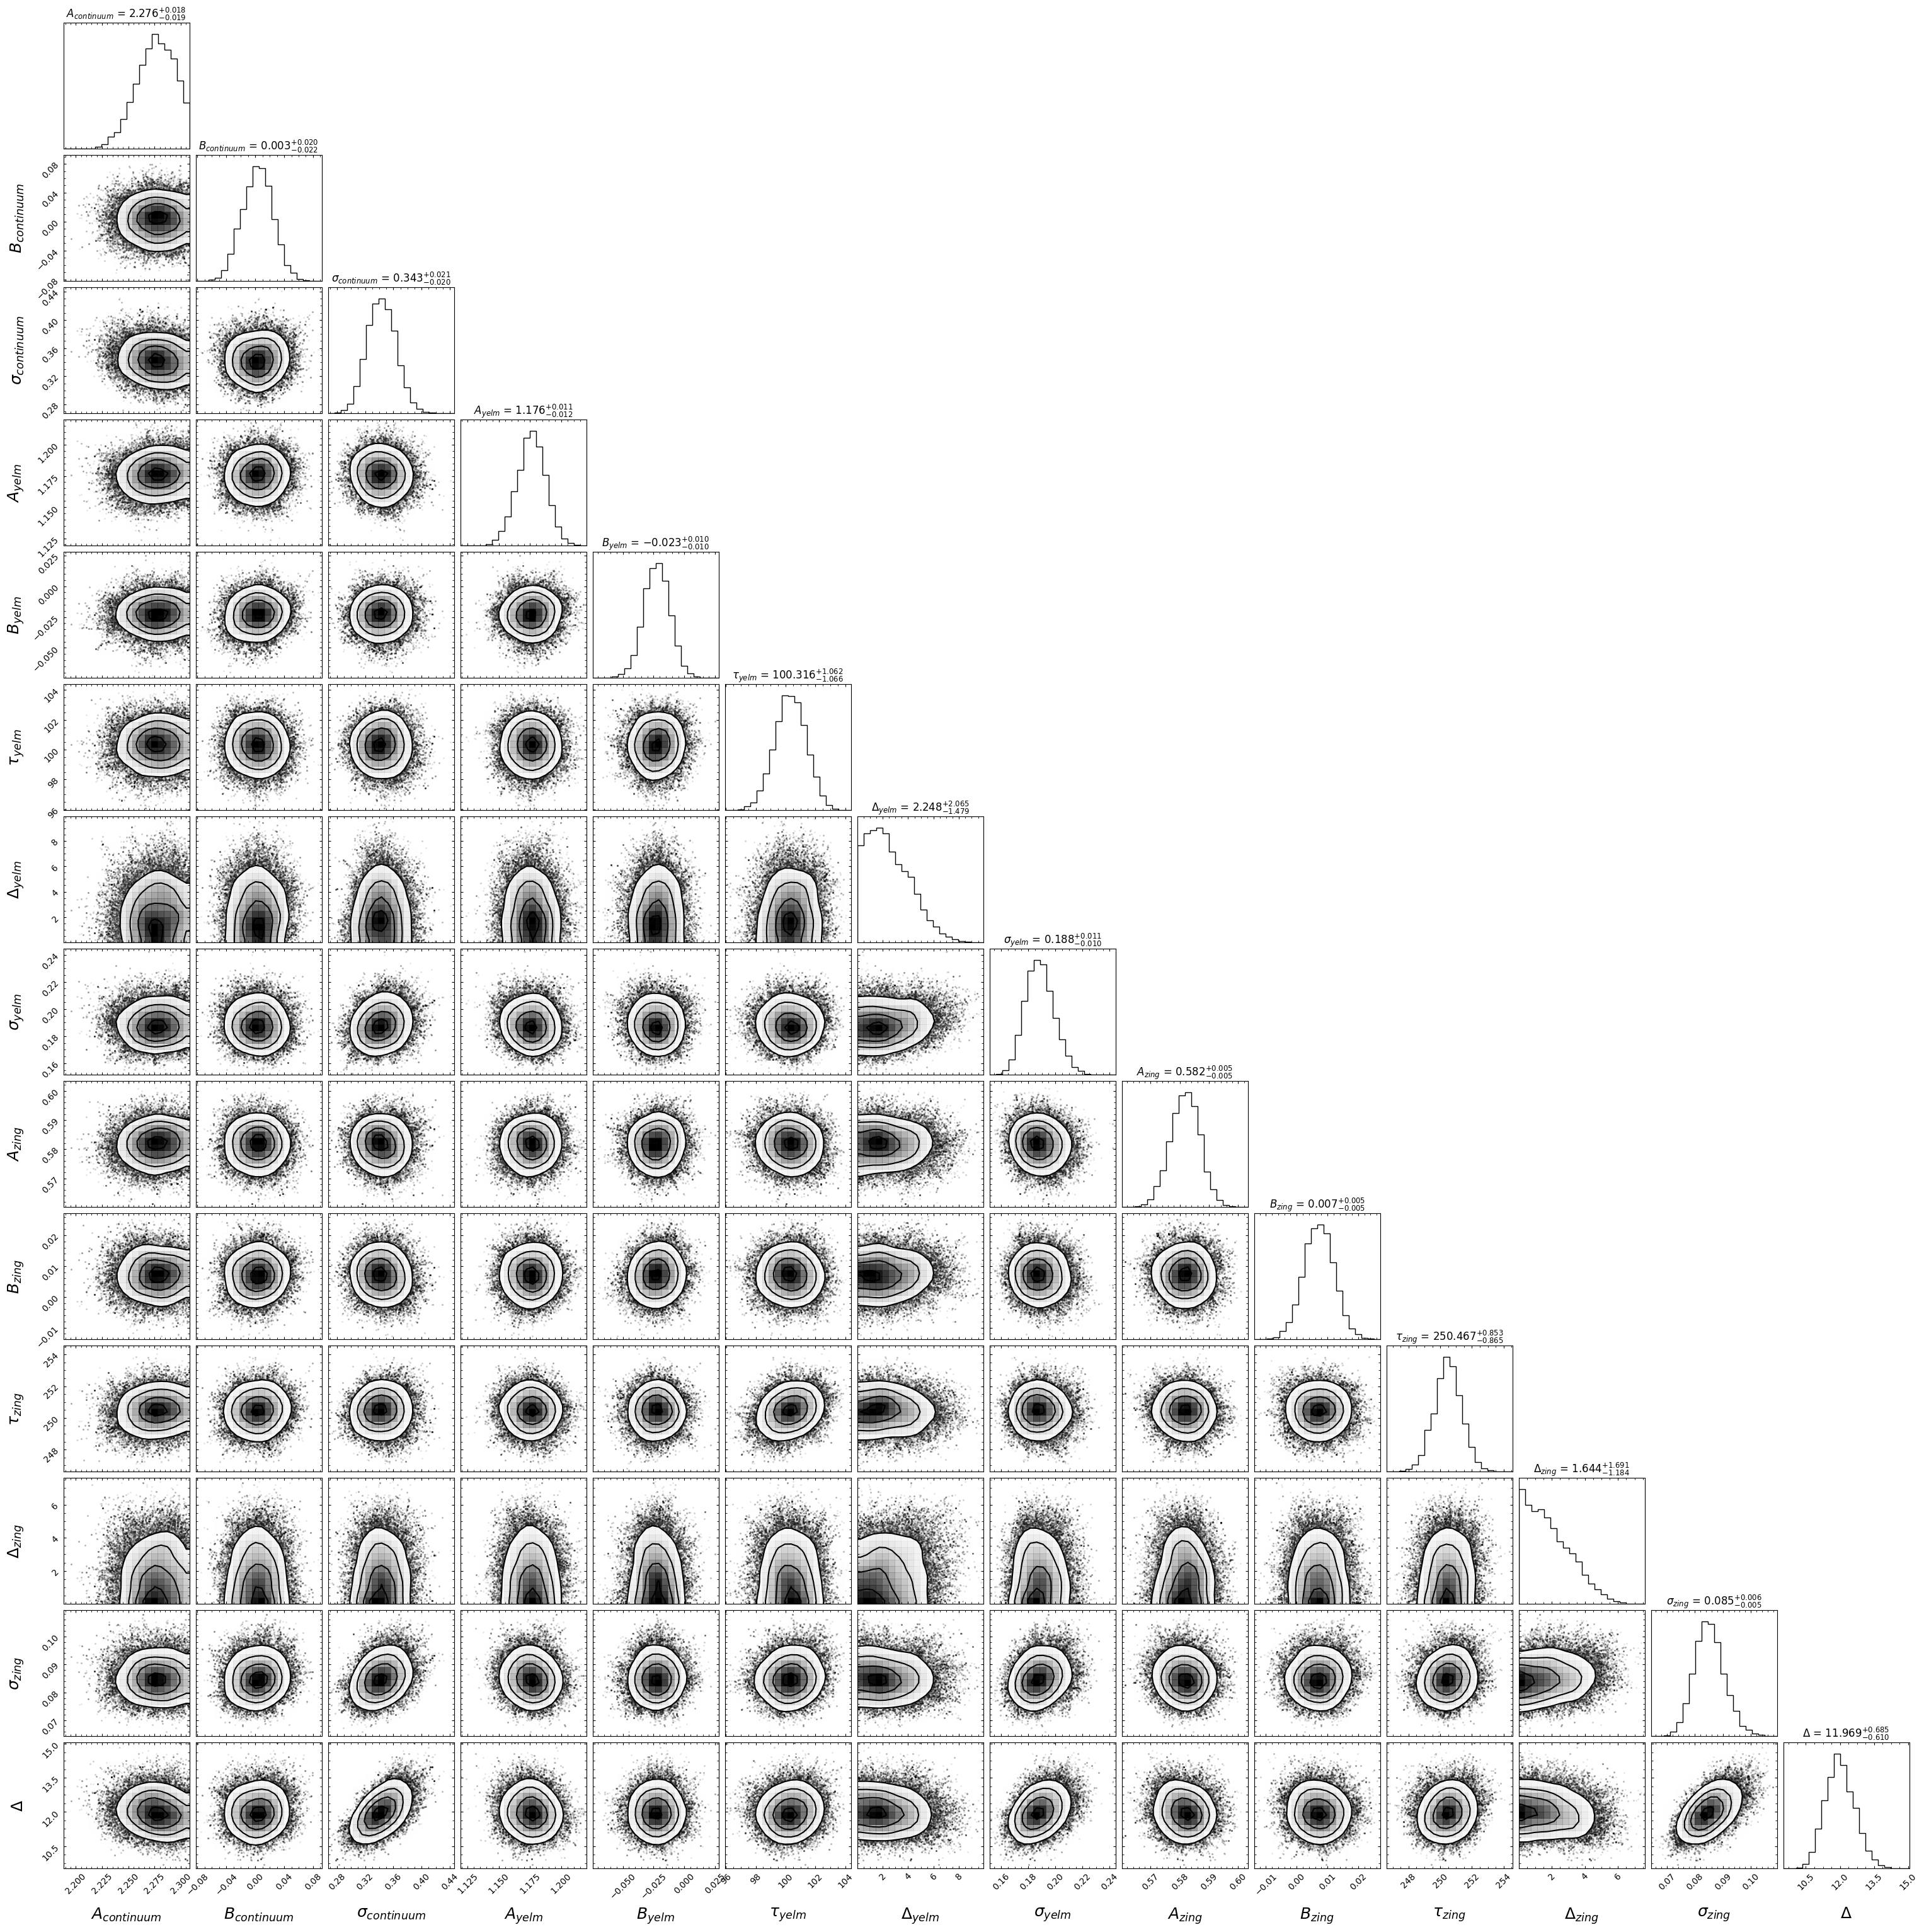

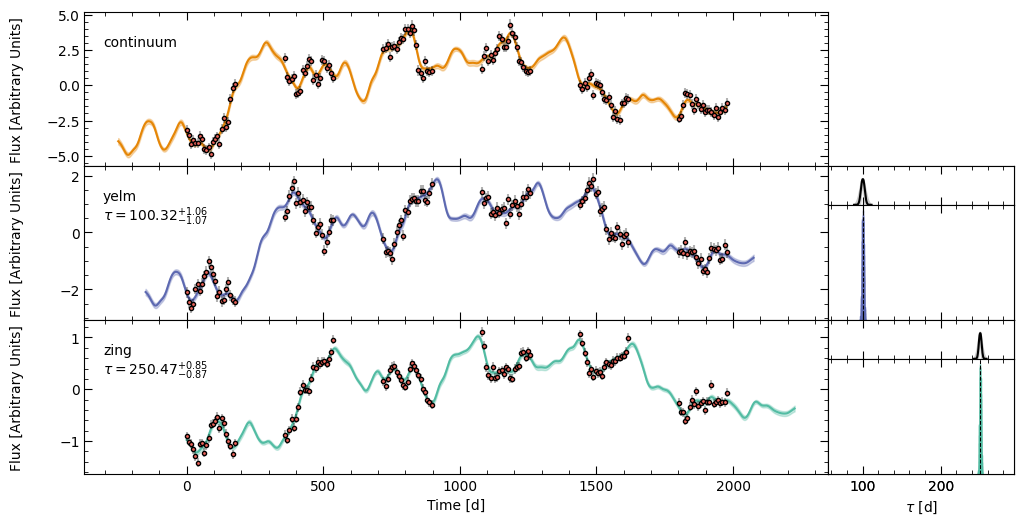

In [2]:
params = {
    'nchain': 7000,
    'nburn': 4000,
    'add_var': True,
    'init_tau': [10., 100.],
    'subtract_mean': True,
    'delay_dist': True
}

res = pl.run_pipeline(output_dir, filenames, line_names,
                      run_pyroa=True, pyroa_params=params,
                      verbose=True, plot=True, time_unit='d',
                      file_fmt='ascii', lag_bounds=[-500, 500])

The RMS of the $\tau_i$ distribution ($\Delta_i$) can be seen in the trace, histogram, and corner plots. The delay distribution (and its uncertainty) can be seen in an inset plot above the $\tau_i$ distribution for each line light curve in the model fit figure. The $\tau_i$ distributions are well-constrained, so the delay distribution error is difficult to see.

In addition, using ``delay_dist=True`` makes PyROA finish much quicker (an order of $\sim$ 5x), comparing to the basic tutorial.

## Accessing the MCMC Samples

Now, we've added a new parameter $\Delta_i$ for each light curve. This changes the order of the chunked samples to give:

$[[A_0, B_0, \tau_0, \Delta_0, \sigma_0],[A_1, B_1, \tau_1, \Delta_1, \sigma_1],[A_2, B_2, \tau_2, \Delta_2, \sigma_2 ], [\Delta]]$

where $\tau_0$ and $\Delta_0$ are set to an array of 0s.

In [4]:
from pypetal.pyroa.utils import get_samples_chunks

samples_chunks = get_samples_chunks(res['pyroa_res'].samples, nburn=4000, add_var=True, delay_dist=True)

print( len(samples_chunks) )
print( samples_chunks[0][2], samples_chunks[0][3] )
print( len(samples_chunks[2]) )

4
[0. 0. 0. ... 0. 0. 0.] [0. 0. 0. ... 0. 0. 0.]
5


If ``add_var`` were set to ``False``, the chunked samples would look like:

$[[A_0, B_0, \tau_0, \Delta_0],[A_1, B_1, \tau_1, \Delta_1],[A_2, B_2, \tau_2, \Delta_2], [\Delta]]$